# Test Model

## This notebook takes you through the steps of how to test a trained model on given test data sets

## required packages:
- numpy
- h5py
- random
- time
- sklearn
- Keras 
  - must be using the same version used to train the model
- Tensorflow or Theano 
  - backend for Keras, must be the same backend that was used to train the model
- Matplotlib and seaborn are only necessary to make plots of predictions vs. ASPCAP Dr12 labels

## required data files:
- model file
  - can be created in $4\_Train\_Model\_Keras\_2.ipynb$ or $4\_Train\_Model\_Keras\_2.ipynb$
- high_snr_test_data.h5
  - can be created in $3\_Preprocessing\_of\_Test\_Data.ipynb$ or downloaded  in $1\_Download\_Data.ipynb$
- low_snr_test_data.h5
  - can be created in $3\_Preprocessing\_of\_Test\_Data.ipynb$ or downloaded  in $1\_Download\_Data.ipynb$
- mean_and_std.npy
  - can be created in $3\_Preprocessing\_of\_Test\_Data.ipynb$ or downloaded in $1\_Download\_Data.ipynb$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import r2_score
import h5py
import time
from scipy.stats import norm
from matplotlib import gridspec

Using TensorFlow backend.


## Obtain data for normalizing labels

In [2]:
mean_and_std = np.load('mean_and_std.npy')
mean_labels = mean_and_std[0]
std_labels = mean_and_std[1]
num_labels = mean_and_std.shape[1]

## Define function to denormalize labels

In [3]:
def normalize(lb):
    return (lb-mean_labels)/std_labels

def denormalize(lb_norm):
    return ((lb_norm*std_labels)+mean_labels)

## Define functions to obtain test data

In [4]:
def get_data(path):
    f = h5py.File(path,"r")
    spectra_array = f['spectra'][:]
    spectra_array = spectra_array.reshape((spectra_array.shape[0],spectra_array.shape[1],1))
    ap_ids = f['Ap_IDs'][:]
    labels_array = np.column_stack((f['TEFF'][:],f['LOGG'][:],f['FE_H'][:]))
    snr_array = f['combined_snr'][:]  
    f.close()
    return  (ap_ids, snr_array, spectra_array, labels_array)

## Load test data

In [5]:
savename_test_1 = ('high_snr_test_data.h5')
test_1_ap_ids, test_1_snr, test_1_spectra, test_1_labels = get_data(savename_test_1)
print('High S/N test set contains ' +str(len(test_1_spectra))+' stars')

savename_test_2 = ('low_snr_test_data.h5')
test_2_ap_ids, test_2_snr, test_2_spectra, test_2_labels = get_data(savename_test_2)
print('Low S/N test set contains ' +str(len(test_2_spectra))+' stars')

High S/N test set contains 3733 stars
Low S/N test set contains 17506 stars


# Load Model

In [6]:
model_name = 'Model_0.h5'
model = load_model(model_name)
print(model_name+' loaded.')

Model_0.h5 loaded.


# Predict on test sets

In [7]:
time1 = time.time()
test_1_pred = denormalize(model.predict(test_1_spectra))
test_2_pred = denormalize(model.predict(test_2_spectra))
print("{0:.2f}".format(time.time()-time1)+' seconds to make '+str(len(test_1_spectra)+len(test_2_spectra))+' predictions')

11.70 seconds to make 21239 predictions


# Plot HIGH_SNR  test set predictions
Note: If top plot does not show gridlines, then simply run the cell again. This is a bug.

In [8]:
# label names
label_names = ['$T_{\mathrm{eff}}$',' $\log(g)$','$[Fe/H]$']

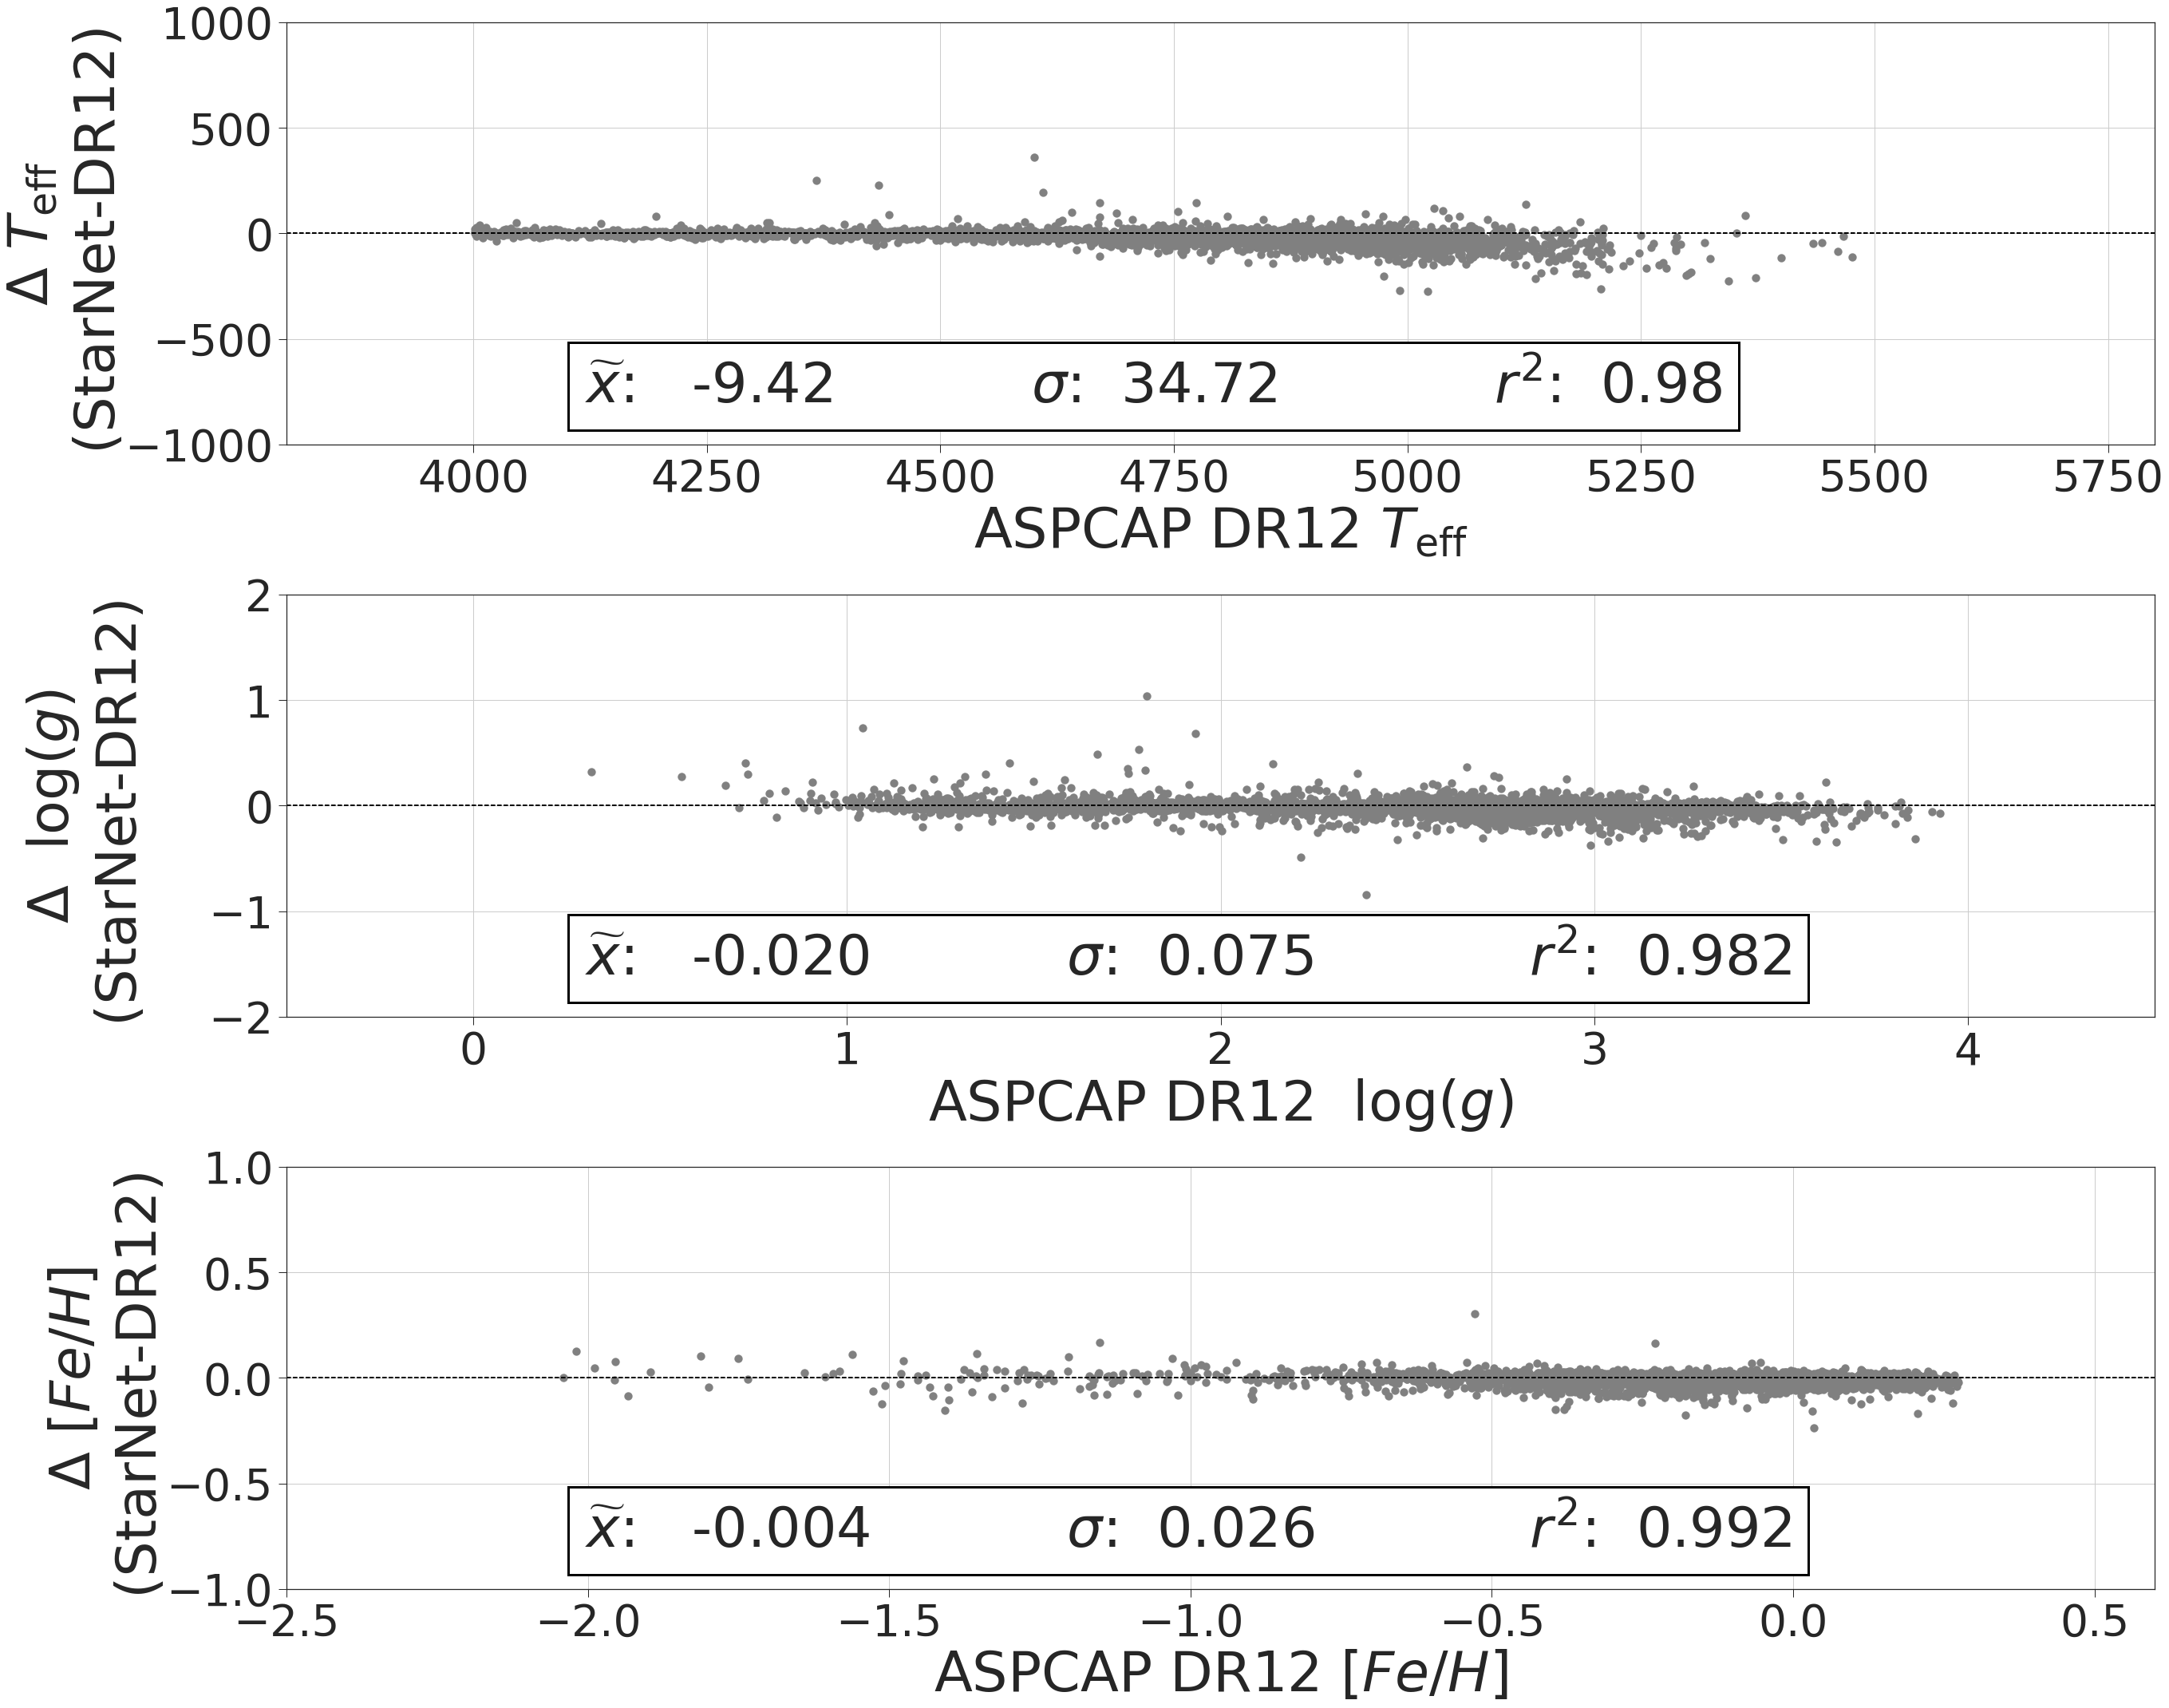

In [10]:
all_targets = test_1_labels
all_pred = test_1_pred

x_lab='DR12'
y_lab='StarNet'

difference = all_pred-all_targets
mean_diff = np.median(difference, axis=0)
std_diff = np.std(difference, axis=0)

r2 = r2_score(all_targets, all_pred,multioutput='raw_values')

lims = [[(3800,5800),(-0.50,4.50),(-2.5,0.6)],[(-1000,1000),(-2.0,2.0),(-1.,1.)]]

fig = plt.figure(figsize=(38, 30)) 
gs = gridspec.GridSpec(3, 1)

for i in range(num_labels):

    ax0 = plt.subplot(gs[i,0])
    ax0.set_facecolor('white')
    ax0.grid(True)
    points = ax0.scatter(test_1_labels[:,i], difference[:,i], c='gray', s=100)

    sns.set_style("ticks")
        
    ax0.set_xlabel('ASPCAP '+x_lab+' ' + label_names[i], fontsize=70)
    if i==1:
        ax0.set_ylabel('$\Delta$ ' + label_names[i]+ '\n('+y_lab+'-'+x_lab+')\n', fontsize=70)
    else:
        ax0.set_ylabel('$\Delta$ ' + label_names[i]+ '\n('+y_lab+'-'+x_lab+')', fontsize=70)  
    
    ax0.tick_params(labelsize=55,width=1,length=10)
    
    ax0.set_xlim(lims[0][i])
    ax0.set_ylim(lims[1][i])
    ax0.plot([lims[0][i][0],lims[0][i][1]], [0,0], 'k--', lw=2)
    

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=3)
    if i==0:
        plt.figtext(0.27, (1-((i*0.332)+0.24)),'$\widetilde{x}$:   '+"{0:.2f}".format(mean_diff[i])+'           $\sigma$:  '+"{0:.2f}".format(std_diff[i])+'            $r^2$:  '+"{0:.2f}".format(r2[i]),
            size=70, bbox=bbox_props)
    else:
        plt.figtext(0.27, (1-((i*0.332)+0.24)),'$\widetilde{x}$:   '+"{0:.3f}".format(mean_diff[i])+'           $\sigma$:  '+"{0:.3f}".format(std_diff[i])+'            $r^2$:  '+"{0:.3f}".format(r2[i]),
            size=70, bbox=bbox_props)

    
plt.tight_layout()

plt.show()


# Plot Low S/N test set predictions

/opt/anaconda3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


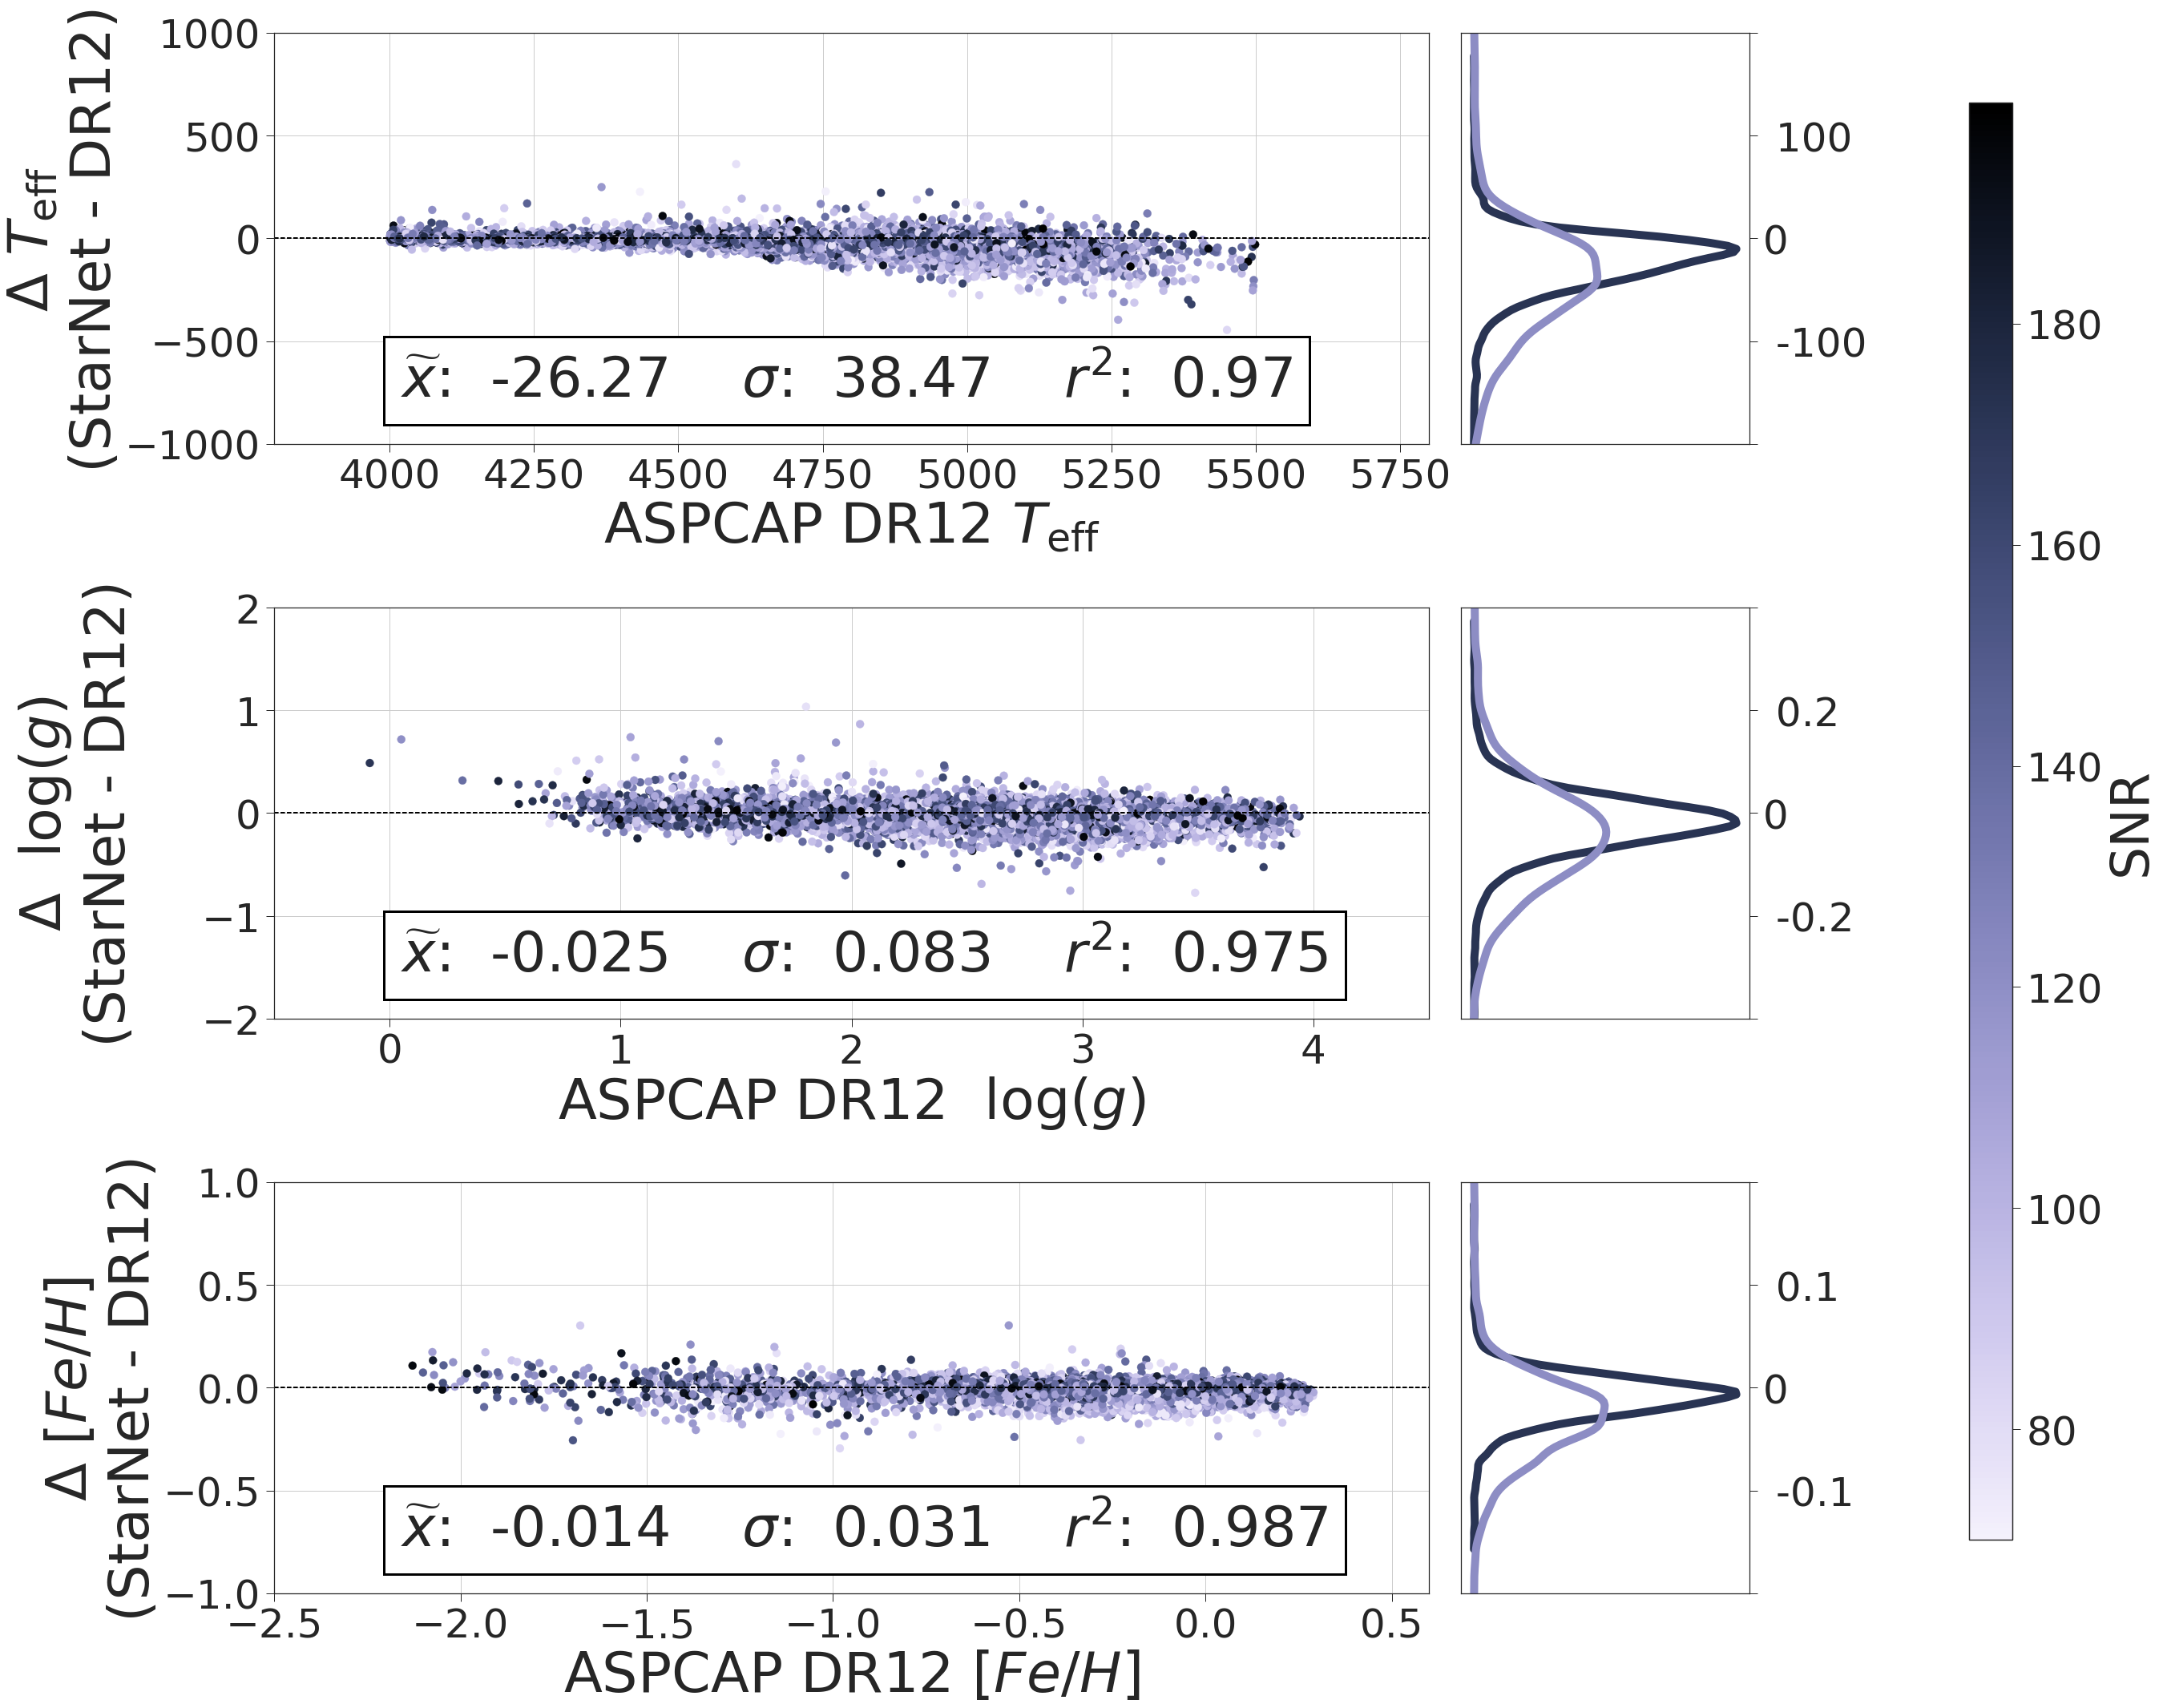

In [11]:
all_targets = test_2_labels
all_pred = test_2_pred
z = test_2_snr

x_lab='DR12'
y_lab='StarNet'


difference = all_pred-all_targets
mean_diff = np.median(difference, axis=0)
std_diff = np.std(difference, axis=0)

indices_a = np.where(z>=150)
indices_b = np.where(z<100)
difference_a = difference[indices_a,:]
difference_b = difference[indices_b,:]

r2 = r2_score(all_targets, all_pred,multioutput='raw_values')


cmap = sns.cubehelix_palette(8, start=2.8, rot=.1, dark=0, light=.95, as_cmap=True)

lims = [[(3800,5800),(-0.50,4.50),(-2.5,0.6)],[(-1000,1000),(-2.0,2.0),(-1.,1.)]]
ditribution_lims = [(-200,200),(-0.4,0.4),(-0.2,0.2)]

fig = plt.figure(figsize=(38, 30)) 
gs = gridspec.GridSpec(3, 2,  width_ratios=[4., 1])


for i in range(num_labels):

    ax0 = plt.subplot(gs[i,0])
    points = ax0.scatter(all_targets[:,i], difference[:,i], c=z, s=100, cmap=cmap)
    sns.set_style("ticks")
    
    ax0.set_xlabel('ASPCAP '+x_lab+' ' + label_names[i], fontsize=70)
    if i==1:
        ax0.set_ylabel('$\Delta$ ' + label_names[i]+ '\n('+y_lab+' - '+x_lab+')\n', fontsize=70)
    else:
        ax0.set_ylabel('$\Delta$ ' + label_names[i]+ '\n('+y_lab+' - '+x_lab+')', fontsize=70)  
    
    ax0.set_facecolor('white')
    ax0.tick_params(labelsize=50,width=1,length=10)
    ax0.set_xlim(lims[0][i])
    ax0.set_ylim(lims[1][i])
    ax0.plot([lims[0][i][0],lims[0][i][1]], [0,0], 'k--', lw=2)    
    ax0.grid(True)
 
    xmin, xmax = ditribution_lims[i]
    
    y_a = difference_a[0,:,i][(difference_a[0,:,i]>=xmin)&(difference_a[0,:,i]<=xmax)]
    y_b = difference_b[0,:,i][(difference_b[0,:,i]>=xmin)&(difference_b[0,:,i]<=xmax)]
    
    ax1 = plt.subplot(gs[i,1])
    a = sns.distplot(y_a, vertical=True,hist=False, rug=False, ax=ax1,kde_kws={"color": cmap(200), "lw": 10})
    b = sns.distplot(y_b,vertical=True,hist=False, rug=False, ax=ax1,kde_kws={"color": cmap(100), "lw": 10})
    
    a.set_ylim(ditribution_lims[i])
    b.set_ylim(ditribution_lims[i])
    
    ax1.tick_params(
    axis='x',          
    which='both',     
    bottom='off',      
    top='off',         
    labelbottom='off',width=1,length=10)
    
    ax1.tick_params(
    axis='y',          
    which='both',   
    left='off',     
    right='on',        
    labelleft='off',
    labelright='on',
    labelsize=50,width=1,length=10)
    
    ax1.set_yticklabels([' ',' '+str(ditribution_lims[i][0]/2),'0',' '+str(ditribution_lims[i][1]/2),' '])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=3)

    
    if i==0:
        plt.figtext(0.185, (1-((i*0.332)+0.24)),'$\widetilde{x}$:  '+"{0:.2f}".format(mean_diff[i])+'    $\sigma$:  '+"{0:.2f}".format(std_diff[i])+'    $r^2$:  '+"{0:.2f}".format(r2[i]),
            size=70, bbox=bbox_props)
    else:
        plt.figtext(0.185, (1-((i*0.332)+0.24)),'$\widetilde{x}$:  '+"{0:.3f}".format(mean_diff[i])+'    $\sigma$:  '+"{0:.3f}".format(std_diff[i])+'    $r^2$:  '+"{0:.3f}".format(r2[i]),
            size=70, bbox=bbox_props)

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.83])
fig.colorbar(points,cax=cbar_ax)
cbar = fig.colorbar(points, cax=cbar_ax, extend='neither', spacing='proportional', orientation='vertical', format="%.0f")
cbar.set_label('SNR', size=65)
cbar.ax.tick_params(labelsize=50,width=1,length=10) 

cbar.ax.set_yticklabels(['80','100','120','140','160','180'])

plt.tight_layout()
fig.subplots_adjust(right=0.8)

plt.show()